# **Поиск ассоциативных правил**

1. Доработайте программу из задания Поиск частых наборов, чтобы она также выполняла поиск ассоциативных правил. Список результирующих правил должен выдаваться в удобочитаемом виде (антецедент→консеквент) с указанием поддержки и достоверности каждого правила. Дополнительные параметры программы: порог достоверности, способ упорядочивания результирующего списка наборов (по убыванию значения поддержки или лексикографическое).
2. Проведите эксперименты на наборах из задания 1. В экспериментах Зафиксируйте значение пороговое значение поддержки (например, 10%), варьируйте пороговое значение достоверности (например, от 70% до 95% с шагом 5%).
3. Выполните визуализацию полученных результатов в виде следующих диаграмм:

- сравнение быстродействия поиска правил на фиксированном наборе данных при изменяемом пороге достоверности;
- общее количество найденных правил на фиксированном наборе данных при изменяемом пороге достоверности.

4. Подготовьте список правил, в которых антецедент и консеквент суммарно включают в себя не более семи объектов (разумное количество). Проанализируйте и изложите содержательный смысл полученного результата.

Подключим используемые библиотеки.

In [5]:
import pandas as pd
import chardet
import time
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules

Загрузим набор данных и посмотрим на него.

In [6]:
filename = 'baskets.csv'
with open(filename, 'rb') as f:
    result = chardet.detect(f.read())

df = pd.read_csv(filename, encoding=result['encoding'])
df

,креветки,миндаль,авокадо,овощная смесь,зеленый виноград,цельнозерновая мука,батат,творог,энергетический напиток,томатный сок,низкокалорийный йогурт,зеленый чай,мед,салат,минеральная вода,лосось,ягодный сок,замороженный смузи,шпинат,оливковое масло
0,гамбургер,фрикадельки,яйца,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,чатни,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,индейка,авокадо,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,минеральная вода,молоко,энергетический батончик,рис,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,низкокалорийный йогурт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,сливочное масло,низкокалорийный майонез,свежий хлеб,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7496,гамбургер,замороженные овощи,яйца,картофель-фри,журнал,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7497,курица,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7498,эскалоп,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Загрузим поиск частых наборов из предыдущего задания.

In [4]:
def run_apriori(data, min_support, sort_by='support'):
    transactions = data.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
    unique_items = sorted(set(item for transaction in transactions for item in transaction))
    encoded_data = pd.DataFrame([[item in transaction for item in unique_items] for transaction in transactions],
                                columns=unique_items)

    frequent_itemsets = apriori(encoded_data, min_support=min_support, use_colnames=True)

    if sort_by == 'support':
        frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
    elif sort_by == 'lexical':
        frequent_itemsets = frequent_itemsets.sort_values(by='itemsets')

    return frequent_itemsets

Сформулируем функцию для поиска ассоциативных правил, которая принимает частые наборы и извлекает из них правила по метрике confidence, после чего фильтрует правила по минимальной достоверности (min_confidence), сортирует по поддержке или лексикографически и возвращает антецеденты (левая часть правила), консеквенты (правая часть), поддержку и достоверность.

In [7]:
def find_association_rules(itemsets, min_confidence, sort_by='support'):
    rules = association_rules(itemsets, metric="confidence", min_threshold=min_confidence)

    if sort_by == 'support':
        rules = rules.sort_values(by='support', ascending=False)
    elif sort_by == 'lexical':
        rules = rules.sort_values(by='antecedents')

    return rules[['antecedents', 'consequents', 'support', 'confidence']]

Запустим поиск частых наборов и ассоциативных правил, чтобы посмотреть, как выглядят полученные данные при минимальной достоверности = 0.7 и минимальной поддержкой 0.002.

In [8]:
min_support = 0.002

itemsets = run_apriori(df, min_support)
rules = find_association_rules(itemsets, min_confidence=0.70)
display(pd.DataFrame(itemsets))
display(pd.DataFrame(rules))

,support,itemsets
47,0.238267,(минеральная вода)
42,0.188000,(макароны)
110,0.179733,(яйца)
28,0.170933,(картофель-фри)
104,0.163867,(шоколад)
...,...,...
712,0.002000,"(корм для животных, минеральная вода)"
713,0.002000,"(креветки, красное вино)"
2587,0.002000,"(креветки, говяжий фарш, шоколад, макароны)"
2590,0.002000,"(говяжий фарш, низкокалорийный йогурт, минерал..."


,antecedents,consequents,support,confidence
0,"(грибной соус, эскалоп)",(макароны),0.004267,0.744186
1,"(растительное масло, яйца, макароны)",(минеральная вода),0.003067,0.718750
2,"(молоко, замороженные овощи, суп)",(минеральная вода),0.003067,0.766667
3,"(шоколад, оливковое масло, замороженные овощи)",(минеральная вода),0.002800,0.700000
4,"(молоко, оливковое масло, яйца)",(минеральная вода),0.002667,0.714286
5,"(креветки, говяжий фарш, замороженные овощи)",(макароны),0.002533,0.791667
6,"(обезжиренное молоко, макароны)",(минеральная вода),0.002533,0.730769
7,"(блинчики, растительное масло, макароны)",(минеральная вода),0.002267,0.739130
8,"(блинчики, суп, макароны)",(минеральная вода),0.002267,0.772727
9,"(помидоры, оливковое масло, замороженные овощи)",(макароны),0.002133,0.842105


Исследуем, как влияет min_confidence на скорость и количество найденных правил. Запустим алгоритм Apriori и поиск правил для каждого значения confidence, замерим время выполнения и посчитаем количество найденных правил.

In [9]:
min_support = 0.002
confidence_values = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]

execution_times = []
rule_counts = []

for confidence in confidence_values:
    start_time = time.time()
    itemsets = run_apriori(df, min_support)
    rules = find_association_rules(itemsets, min_confidence=confidence)
    exec_time = time.time() - start_time

    execution_times.append(exec_time)
    rule_counts.append(len(rules))

Построим график зависимости времени выполнения от порога достоверности. На нем видно, что при росте порога достоверности время выполнения в среднем снижается, но скачкообразно.

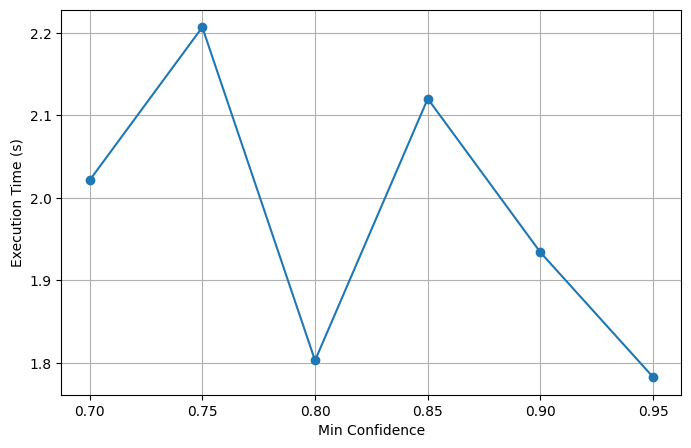

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(confidence_values, execution_times, marker='o', linestyle='-')
plt.xlabel("Min Confidence")
plt.ylabel("Execution Time (s)")
plt.grid()
plt.show()

Построим график количества найденных правил от порога достоверности. На нем видно, что при значении support 0.002 и увеличении порога достоверности, количество правил начинается снижаться. При пороге 0.9 количество правил становится равной нулю, это говорит о том, что высокая достоверность присутствует только у небольшого числа правил.

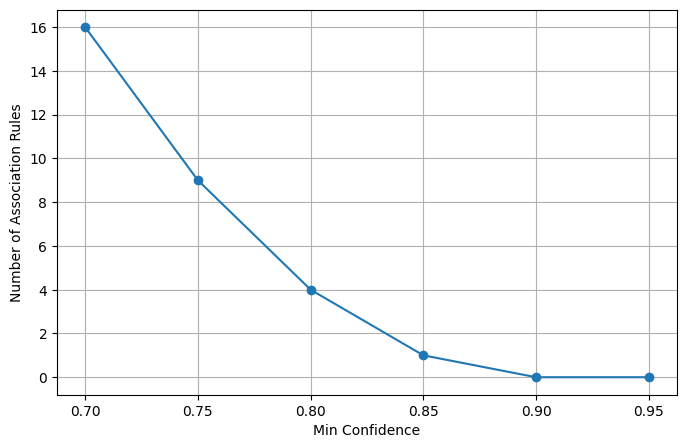

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(confidence_values, rule_counts, marker='o', linestyle='-')
plt.xlabel("Min Confidence")
plt.ylabel("Number of Association Rules")
plt.grid()
plt.show()

Проведем эксперименты. Найдем все частые наборы и ассоциативные правила, отфильтруем правила, где количество элементов в антецеденте и консеквенте не превышает семь, и выведем эти правила.

In [12]:
min_support = 0.002
min_confidence = 0.65

frequent_itemsets = run_apriori(df, min_support)
rules = find_association_rules(itemsets, min_confidence=min_confidence)

filtered_rules = rules[rules.apply(lambda row: len(row['antecedents']) + len(row['consequents']) <= 7, axis=1)]

# Правила, в которых антецедент и консеквент суммарно включают в себя не более семи объектов
filtered_rules

,antecedents,consequents,support,confidence
0,"(грибной соус, эскалоп)",(макароны),0.004267,0.744186
1,"(молоко, говяжий фарш, замороженные овощи)",(минеральная вода),0.003733,0.651163
2,"(молоко, оливковое масло, замороженные овощи)",(минеральная вода),0.003333,0.694444
3,"(говяжий фарш, рис, макароны)",(минеральная вода),0.003067,0.657143
4,"(говяжий фарш, хлопья)",(макароны),0.003067,0.676471
5,"(растительное масло, яйца, макароны)",(минеральная вода),0.003067,0.718750
6,"(молоко, замороженные овощи, суп)",(минеральная вода),0.003067,0.766667
7,"(шоколад, оливковое масло, замороженные овощи)",(минеральная вода),0.002800,0.700000
8,"(молоко, оливковое масло, яйца)",(минеральная вода),0.002667,0.714286
9,"(протеиновый батончик, яйца)",(минеральная вода),0.002667,0.689655
